Importing the necessary libraries

In [3]:
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
import pandas as pd
import pickle
import dill as pickle
import nltk
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/stack")
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/stack'

Reading the dataset

In [8]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,Id,Title,Body,Tags
0,0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [9]:
df.dtypes

Unnamed: 0     int64
Id             int64
Title         object
Body          object
Tags          object
dtype: object

In [10]:
print("Dataframe shape : ", df.shape)

Dataframe shape :  (100000, 5)


Removing duplicate questions

In [11]:
duplicate_pairs = df.sort_values('Title', ascending=False).duplicated('Title')
print("Total number of duplicate questions : ", duplicate_pairs.sum())
df = df[~duplicate_pairs]
print("Dataframe shape after duplicate removal : ", df.shape)

Total number of duplicate questions :  595
Dataframe shape after duplicate removal :  (99405, 5)


Counting the number of tags

In [12]:
df["tag_count"] = df["Tags"].apply(lambda x : len(x.split()))

In [13]:
df.head()

,Unnamed: 0,Id,Title,Body,Tags,tag_count
0,0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


In [14]:
df["tag_count"].value_counts()

3    28592
2    26377
4    19003
1    13780
5    11653
Name: tag_count, dtype: int64

In [15]:
print( "Maximum number of tags in a question: ", df["tag_count"].max())
print( "Minimum number of tags in a question: ", df["tag_count"].min())
print( "Average number of tags in a question: ", df["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.8830239927569035


Visualization of number of tags

Text(0, 0.5, 'Frequency')

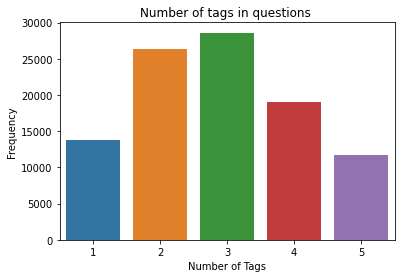

In [16]:
sns.countplot(df["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

Implementing Bag of words model for visualization

In [17]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
#pickle.dump(vectorizer,open('vect_bow.pkl','wb'))
tag_bow = vectorizer.fit_transform(df['Tags'])


In [18]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 99405
Number of unique tags : 18446


In [19]:
tags = vectorizer.get_feature_names()
print("Few tags :", tags[:10])

Few tags : ['.a', '.bash-profile', '.class-file', '.each', '.emf', '.hgtags', '.htaccess', '.htpasswd', '.mov', '.net']


Frequency count of each tag

In [20]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [21]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

In [22]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,2
1,.bash-profile,1
2,.class-file,1
3,.each,6
4,.emf,2


Text(0, 0.5, 'Frequency')

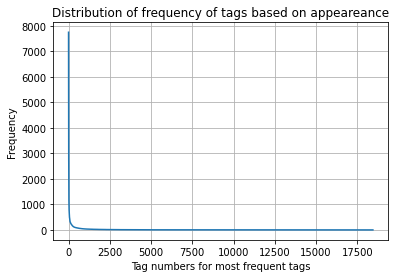

In [23]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

In [24]:
tag_df_sorted

,Tags,Counts
2010,c#,7745
8043,java,6751
11935,php,6543
8085,javascript,6102
569,android,5287
...,...,...
12935,r-tree,1
12934,r-faq,1
6258,get-the-category,1
6261,getaddrinfo,1


In [25]:
tag_df_sorted.shape

(18446, 2)

Text(0, 0.5, 'Frequency')

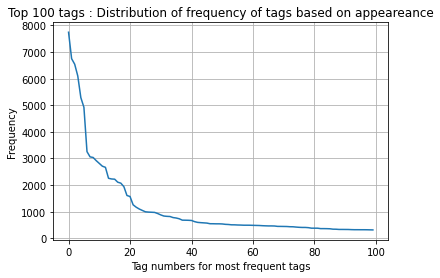

In [26]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

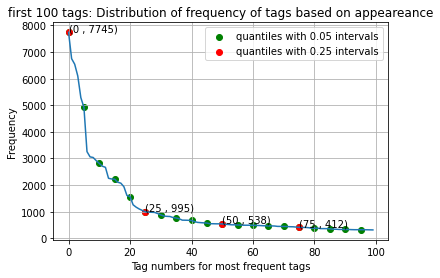

In [27]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.scatter(x=np.arange(0,100,5), y=tag_df_sorted['Counts'][0:100:5], c='g', label="quantiles with 0.05 intervals")
plt.scatter(x=np.arange(0,100,25), y=tag_df_sorted['Counts'][0:100:25], c='r', label = "quantiles with 0.25 intervals")
for x,y in zip(np.arange(0,100,25), tag_df_sorted['Counts'][0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.01, y+30))

plt.title('first 100 tags: Distribution of frequency of tags based on appeareance')
plt.grid()
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.legend()

In [28]:
print("{} tags are used more than 25 times".format(tag_df_sorted[tag_df_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_sorted[tag_df_sorted["Counts"]>50].shape[0]))

1481 tags are used more than 25 times
793 tags are used more than 50 times


In [29]:
type(tag_to_count_map)

dict

In [30]:
tag_to_count_map.items()

dict_items([('.a', 2), ('.bash-profile', 1), ('.class-file', 1), ('.each', 6), ('.emf', 2), ('.hgtags', 2), ('.htaccess', 331), ('.htpasswd', 1), ('.mov', 1), ('.net', 2667), ('.net-1.1', 3), ('.net-2.0', 31), ('.net-3.5', 84), ('.net-4.0', 125), ('.net-4.5', 17), ('.net-assembly', 22), ('.net-cf-3.5', 1), ('.net-framework', 5), ('.net-install', 1), ('.net-micro-framework', 2), ('.net-remoting', 4), ('.net-security', 1), ('.net2.0', 1), ('.net3.5', 1), ('.net4.0', 2), ('.nettiers', 2), ('.obj', 1), ('.post', 4), ('.rdlc', 1), ('.refresh', 1), ('.sdf', 1), ('.war', 1), ('.wav', 1), ('.x', 2), ('1080p', 2), ('10gbethernet', 2), ('10gige', 1), ('16bit', 2), ('1and1', 2), ('2-legged', 1), ('2-tier', 1), ('2003', 2), ('2007', 71), ('2010', 106), ('2013', 13), ('24bit', 1), ('24hour', 1), ('2d', 35), ('2d-array', 9), ('2d-games', 1), ('2wire', 2), ('3-tier', 3), ('3.0', 14), ('3.0.1', 1), ('3.1', 1), ('301', 2), ('301-redirect', 1), ('32-bit', 13), ('32-vs-64-bit', 1), ('3270', 1), ('32bit',

In [31]:
type(tag_to_count_map.items())

dict_items

Creating a WordCloud of the tags based on their frequency

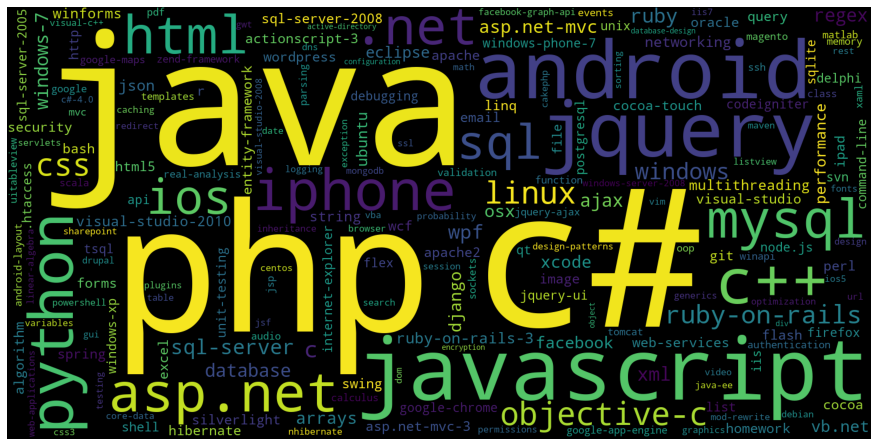

In [32]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

Frequency of top 25 tags

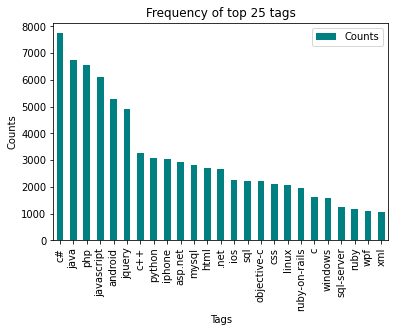

In [33]:
i=np.arange(25)
tag_df_sorted.head(25).plot(kind='bar',color='teal')
plt.title('Frequency of top 25 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [34]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

Pre-processing the text data and merging the title and body into one variable

In [35]:
qus_list=[]
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(body)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)

df["question"] = qus_list

Creating a new dataframe having questions and tags

In [36]:
preprocessed_df = df[["question","Tags"]]
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (99405, 2)


In [37]:
preprocessed_df.head()

,question,Tags
0,check upload file imag without mime type like ...,php image-processing file-upload upload mime-t...
1,prevent firefox close press ctrl favorit edito...,firefox
2,error invalid type list variabl import matlab ...,r matlab machine-learning
3,replac special charact url probabl simpl simpl...,c# url encoding
4,modifi whoi contact detail use modifi function...,php api file-get-contents


Implementing Bag of words model

In [38]:
vectorizer2 = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
#pickle.dump(vectorizer2,open('vect_bow2.pkl','wb'))
y_multilabel = vectorizer2.fit_transform(preprocessed_df['Tags'])

In [39]:
y_multilabel.shape

(99405, 18446)

In [40]:
tags_data=[]

It returns a 2-d matrix of total number of questions and n-most frequent tags 

In [41]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel


It returns the count of questions which have no tags (n-most frequent) present in them

In [42]:
def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [43]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=y_multilabel.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))
    

Plot of percent of questions covered vs number of tags  

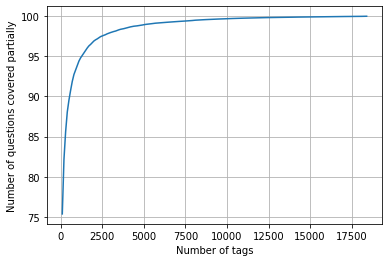

97.545 % of questions covered by 2500 tags


In [44]:
plt.plot(np.arange(100,total_tags, 100),questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[24],"% of questions covered by 2500 tags")
#print("Number of questions that are not covered by 100 tags : ", questions_covered_fn(1000),"out of ", total_qus)

Creating a matrix having all questions and 2500 most frequent tags

In [45]:
yx_multilabel = tags_to_consider(2500)
print("Number of tags in the subset :", y_multilabel.shape[1])
print("Number of tags considered :", yx_multilabel.shape[1],"(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

Number of tags in the subset : 18446
Number of tags considered : 2500 ( 13.553073837146265 %)


Using train-test split to split the data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 79524
Number of data points in test data : 19881


Applying the TF-IDF model

In [47]:
vectorizer = TfidfVectorizer(min_df=0.00009, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [48]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (79524, 89041) Y : (79524, 2500)
Test data shape X :  (19881, 89041) Y: (19881, 2500)


Applying SGD model using 'log' as loss function

In [49]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [50]:
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))
print("Hamming loss ",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.08364770383783512
Hamming loss  0.0008511241889240983


In [51]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))
print("Precision recall report :\n",metrics.classification_report(y_test, y_pred))

Accuracy : 0.08364770383783512
Macro f1 score : 0.03969276020017165
Micro f1 scoore : 0.2792250941370909
Hamming loss : 0.0008511241889240983
Precision recall report :
               precision    recall  f1-score   support

           0       0.62      0.17      0.27      1569
           1       0.79      0.36      0.49      1348
           2       0.82      0.47      0.60      1339
           3       0.78      0.38      0.51      1261
           4       0.95      0.66      0.78      1084
           5       0.86      0.58      0.69       994
           6       0.67      0.23      0.34       645
           7       0.88      0.49      0.63       621
           8       0.74      0.31      0.44       577
           9       0.79      0.35      0.48       573
          10       0.88      0.53      0.66       553
          11       0.53      0.14      0.22       540
          12       0.70      0.10      0.17       502
          13       0.63      0.19      0.30       465
          14       0

Adding the title thrice int he question to elevate it's importance

In [52]:
qus_list=[]

for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(title)+" "+str(title)+" "+ body
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)

df["question_with_more_wt_title"] = qus_list

In [53]:
preprocessed_df = df[["question_with_more_wt_title","Tags"]]
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (99405, 2)


Using train-test split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 79524
Number of data points in test data : 19881


Applying the TF-IDF model

In [55]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question_with_more_wt_title'])
X_test_multilabel = vectorizer.transform(X_test['question_with_more_wt_title'])
#pickle.dump(vectorizer,open('model.pkl','wb'))

In [56]:
X_train.dtypes

question_with_more_wt_title    object
Tags                           object
dtype: object

In [57]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (79524, 90610) Y : (79524, 2500)
Test data shape X :  (19881, 90610) Y: (19881, 2500)


Applying Logistic Regression model using 'saga' as solver

In [58]:
classifier1 = OneVsRestClassifier(LogisticRegression(C=0.01, penalty='l1',solver='saga'))
classifier1.fit(X_train_multilabel, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='saga', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [59]:
pred1 = classifier1.predict(X_test_multilabel)

In [60]:
print("Accuracy :",metrics.accuracy_score(y_test, pred1))
print("Hamming loss ",metrics.hamming_loss(y_test,pred1))


precision = precision_score(y_test, pred1, average='micro')
recall = recall_score(y_test, pred1, average='micro')
f1 = f1_score(y_test, pred1, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, pred1, average='macro')
recall = recall_score(y_test, pred1, average='macro')
f1 = f1_score(y_test, pred1, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, pred1))


Accuracy : 0.04914239726371913
Hamming loss  0.0009160907399024194
Micro-average quality numbers
Precision: 0.8935, Recall: 0.0549, F1-measure: 0.1034
Macro-average quality numbers
Precision: 0.0078, Recall: 0.0012, F1-measure: 0.0018
              precision    recall  f1-score   support

           0       0.11      0.00      0.00      1569
           1       0.85      0.25      0.38      1348
           2       0.89      0.35      0.51      1339
           3       0.91      0.24      0.39      1261
           4       0.97      0.46      0.62      1084
           5       0.90      0.44      0.59       994
           6       0.67      0.01      0.01       645
           7       0.92      0.33      0.49       621
           8       0.96      0.08      0.15       577
           9       0.63      0.03      0.06       573
          10       0.91      0.32      0.47       553
          11       0.00      0.00      0.00       540
          12       0.00      0.00      0.00       502
        

Applying SGD model using 'log' as loss function

In [61]:
classifier2 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
classifier2.fit(X_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [62]:
pred2 = classifier2.predict(X_test_multilabel)

In [63]:
print("Accuracy :",metrics.accuracy_score(y_test, pred2))
print("Hamming loss ",metrics.hamming_loss(y_test,pred2))


precision = precision_score(y_test, pred2, average='micro')
recall = recall_score(y_test, pred2, average='micro')
f1 = f1_score(y_test, pred2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, pred2, average='macro')
recall = recall_score(y_test, pred2, average='macro')
f1 = f1_score(y_test, pred2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Accuracy : 0.09234947940244455
Hamming loss  0.0008288315477088678
Micro-average quality numbers
Precision: 0.7701, Recall: 0.1981, F1-measure: 0.3152
Macro-average quality numbers
Precision: 0.1418, Recall: 0.0357, F1-measure: 0.0531


Applying SGD model using 'hinge' as loss function

In [64]:
clf3 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
clf3.fit(X_train_multilabel, y_train)
y_pred = clf3.predict(X_test_multilabel)

In [66]:
print("Accuracy :",metrics.accuracy_score(y_test, y_pred))
print("Hamming loss ",metrics.hamming_loss(y_test,y_pred))


precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, y_pred))


Accuracy : 0.13600925506765255
Hamming loss  0.0007528595141089483
Micro-average quality numbers
Precision: 0.7895, Recall: 0.2971, F1-measure: 0.4317
Macro-average quality numbers
Precision: 0.3153, Recall: 0.2015, F1-measure: 0.2299
              precision    recall  f1-score   support

           0       0.64      0.22      0.33      1569
           1       0.83      0.47      0.60      1348
           2       0.84      0.53      0.65      1339
           3       0.85      0.42      0.56      1261
           4       0.94      0.78      0.85      1084
           5       0.87      0.64      0.73       994
           6       0.76      0.28      0.41       645
           7       0.89      0.67      0.77       621
           8       0.75      0.41      0.53       577
           9       0.83      0.44      0.57       573
          10       0.89      0.59      0.71       553
          11       0.55      0.04      0.07       540
          12       0.75      0.10      0.18       502
        

Conclusion

In [72]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Sr.No","MODEL","PENALTY","MICRO_F1_SCORE","MACRO_F1_SCORE","HAMMING_LOSS"]

In [74]:
x.add_row(["1", 'OneVsRest+Logistic Regression',"l1",0.1034,0.0018,0.0009])
x.add_row(["2", 'OneVsRest+SGD(loss=log)',"l2",0.3152,0.0531,0.0008])
x.add_row(["3", 'OneVsRest+SGD(loss=hinge)',"l1",0.4317,0.2299,0.0007])

print(x)

+-------+-------------------------------+---------+----------------+----------------+--------------+
| Sr.No |             MODEL             | PENALTY | MICRO_F1_SCORE | MACRO_F1_SCORE | HAMMING_LOSS |
+-------+-------------------------------+---------+----------------+----------------+--------------+
|   1   | OneVsRest+Logistic Regression |    l1   |     0.1034     |     0.0018     |    0.0009    |
|   2   |    OneVsRest+SGD(loss=log)    |    l2   |     0.3152     |     0.0531     |    0.0008    |
|   3   |   OneVsRest+SGD(loss=hinge)   |    l1   |     0.4317     |     0.2299     |    0.0007    |
+-------+-------------------------------+---------+----------------+----------------+--------------+
